2022's test of 2003's https://arxiv.org/ftp/arxiv/papers/2003/2003.02735.pdf

## Load Libraries

In [43]:
import os
import io
import json
from os.path import exists
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

try:
  import google.colab
  from google.colab import drive, files
  runnin_in_colab = True
except:
  runnin_in_colab = False


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow import keras
import keras.backend as K
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.experimental import RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

from tensorflow.keras.layers import Normalization, Input
from tensorflow.keras.metrics import Recall, Precision

import mlflow.sklearn

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [44]:
drop_policy="hard" 

do_viz=False

#if we dont do prescale, normalize layer will do it in model
do_scale=True
scaler = MinMaxScaler()

model_complexity="vanilla" # "full" or "vanilla"
n_epochs=10
batch_size=32
initial_learning_rate = 0.001 
use_expo_decay=True

save_model=True

## load data

In [3]:
auth_file=".mocap_bucket_auth_data.json"

tgz_file="smoking_data.tar.gz"
data_dir="smoking_data"
data_features_file='smoking_input.csv'
data_target_file='smoking_targets.csv'
google_drive_dir="mocap"

other_source_loc="https://ifestos.cse.sc.edu/datasets/smoking_data.tar.gz"

#set to None if whole file
#beware, y=0 were concatted to y=1 => use n_rows=some_value only for data_viz or eyballing data
n_rows=None 

In [4]:
if not exists(data_dir) : 
  rc=1;

  if runnin_in_colab:
    source_loc="google drive"
    if not exists("/content/drive"):
      drive.mount('/content/drive')

    os.chdir("/content/drive/MyDrive/{}".format(google_drive_dir))

    if exists(auth_file):
      if os.system("gcloud auth activate-service-account --key-file="+auth_file) == 0 : 
        print("getting data set form bucket...")
        rc = os.system("gsutil cp gs://mocap_data/{} .".format(tgz_file))
        
  if rc == 1 :    
    print("getting data set form {}".format(other_source_loc))
    rc=os.system("wget -q {}".format(other_source_loc))    

  if rc == 1 : 
    raise UserWarning("cant get {} from {}, abort...".format(tgz_file, source_loc))

  os.system("tar -xf {} ; /bin/rm -f {}".format(tgz_file, tgz_file))

if not exists(data_dir) : raise Exception("dont have data dir {}, abort...".format(data_dir))

In [5]:
#nb, this ifestos csv has no header
try:
  X_data=pd.read_csv(data_dir+"/"+data_features_file, nrows=n_rows, header=None)
  X_data_columns=X_data.columns
  y_data=pd.read_csv(data_dir+"/"+data_target_file, nrows=n_rows, header=None)
  y_data.rename(columns={0: "y"}, inplace=True)
except : 
   raise Exception("missing/messy features/target files {}, {}".format(data_features_file, data_target_file)) 

if (len(X_data) != len(y_data)):
   raise Exception("data lens mismatch, X: {}, y: {}".format(len(X_data), len(y_data)))
                   
data = pd.concat([X_data, y_data], axis=1)

del X_data, y_data

## nans

There are some NAN values, lets just drop them for now from both the input and target data sets

In [6]:
print("data shape {}".format(data.shape))
print("y val counts {}".format(data["y"].value_counts()))

data shape (351530, 301)
y val counts 1    177450
0    174080
Name: y, dtype: int64


In [45]:
compute_shifted_data=False
if compute_shifted_data:
    rep_vals=data.iloc[-1][:-1].tolist()
    i=len(data)-1
    n_vals_2_compare=3
    n_vals_2_compare_m1=n_vals_2_compare-1
    nshifts=0
    nyzero=0
    while i > 0 : 
      i-=1
      if data.iloc[i]["y"] == 1 : break
      nyzero+=1
      row=data.iloc[i][:-1].tolist()
      c = sum(el in row[:n_vals_2_compare] for el in rep_vals[:n_vals_2_compare])
      if c == n_vals_2_compare_m1:
        nshifts+=1
      rep_vals=row
    print(nshifts, nyzero)

In [8]:
shape_raw=data.shape

if drop_policy == "soft" :
  #soft or hard, soft allows 1 nan value of X (len(X_data_columns)-1), doing soft would
  #imply imputing, hard just drops a whole row on any nan 
  if False:
    #imputer is not realized in code => soft is not ready...
    data_clean=data.dropna(subset=[data.columns[-1]], axis=0, inplace=False)
    data_clean=data_clean.dropna(subset=X_data_columns, thresh=(len(X_data_columns)-1), axis=0, inplace=False)
  else : 
    data_clean=data.dropna(inplace=False, axis=0)
else:
  data_clean=data.dropna(inplace=False, axis=0)

print(shape_raw, data_clean.shape)

#soft: 351530, 301) (331580, 301)

(351530, 301) (331580, 301)


**Trust but verify**

In [9]:
data_clean.isnull().sum().sum()

0

In [10]:
X = data_clean.drop('y', axis=1)
y = data_clean.y
y.value_counts()

0    174080
1    157500
Name: y, dtype: int64

In [11]:
X.isnull().sum().sum()

0

The observations are for 5 seconds at 20Hz = 100 data points for the 3 acceleromters (100 X 3 = 300 data points). Let's splice the 300 columns/datapoints backing into the individual x,y,z set of data points

Lets create a simple plot for a simple visual comparison of the pattern for the first 5 observations

## train/test/val

In [12]:
if do_viz :
    Xx=X.iloc[0:,:100]
    Xy=X.iloc[0:,100:200]
    Xz=X.iloc[0:,200:300]

    hz=np.arange(0,100)

    for i in range (0,20):
        plt.plot(hz,Xx.iloc[i],'b', label="X" )
        plt.plot(hz,Xy.iloc[i],'g', label="Y" )
        plt.plot(hz,Xz.iloc[i],'r', label="Z" )
        plt.title("Human Gesture")
        plt.xlabel("20 Hz, 5 Seconds")
        plt.ylabel("Accelerometer x,y,z")

    plt.show;

    hz=np.arange(0,100)
    l=len(Xx)-20-1
    for i in range (0,20):
        plt.plot(hz,Xx.iloc[l+i],'b', label="X" )
        plt.plot(hz,Xy.iloc[l+i],'g', label="Y" )
        plt.plot(hz,Xz.iloc[l+i],'r', label="Z" )
        plt.title("Human Gesture")
        plt.xlabel("20 Hz, 5 Seconds")
        plt.ylabel("Accelerometer x,y,z")

    plt.show;

    print(Xx.shape, Xy.shape, Xz.shape)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [14]:
if do_scale :  
  X_train_scaled = scaler.fit_transform(X_train)
  X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
  X_val_scaled =  scaler.transform(X_val)
  X_val = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)

In [15]:
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"X_val.shape = {X_val.shape}")
print(f"y_val.shape = {y_val.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (162474, 300)
y_train.shape = (162474,)
X_val.shape = (69632, 300)
y_val.shape = (69632,)
X_test.shape = (99474, 300)
y_test.shape = (99474,)


In [ ]:
dft=X_train.head(10).copy()
dft["y"]=y_train
dft

In [ ]:
dft.isnull().sum().sum()

## model

In [ ]:
X_train.shape[-1]

In [ ]:
#https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
#https://stats.stackexchange.com/questions/526966/using-batchnorm-and-dropout-simultaneously

def init_full_model():
    
    if model_complexity != "full" : return
        
    input_shape = X_train.shape[1:]
    
    if do_scale == False :
      normalizer = Normalization()
      normalizer.adapt(X_train)
    
    reg = regularizers.l1_l2(l2=0.01)
    
    model = models.Sequential()
    
    if do_scale == False :model.add(normalizer)
        
    model.add(layers.Dense(X_train.shape[-1], activation='relu', kernel_regularizer=reg, input_dim = X_train.shape[-1]))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='relu', kernel_regularizer=reg))   
    model.add(layers.BatchNormalization()) 
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

In [17]:
def init_vanilla_model():
    
    if model_complexity != "vanilla" : return
    
    input_shape = X_train.shape[1:]
    
    if do_scale == False :
      normalizer = Normalization()
      normalizer.adapt(X_train)
    
    model = models.Sequential()
    model.add(Input(X_train.shape[-1]))
    
    if do_scale == False : model.add(normalizer)
    
    model.add(layers.Dense(X_train.shape[-1], activation='relu'))        
    model.add(layers.Dense(int(X_train.shape[-1]/2), activation='relu'))  
    model.add(layers.Dense(int(X_train.shape[-1]/3), activation='relu')) 
    model.add(layers.Dense(10, activation='relu'))    
    model.add(layers.Dense(1, activation = 'sigmoid'))
      
    return model

In [18]:
print("using {} model".format(model_complexity))

try:
  del model
except:
  pass

if model_complexity == "full" :
  model = init_full_model()   
else :
  model = init_vanilla_model()
  
# Model compilation
if use_expo_decay :
   lr = ExponentialDecay(initial_learning_rate, 
                               decay_steps = 200, 
                               decay_rate = 0.5)
   print("using expo decay learning rate")
else:
   lr = initial_learning_rate
   print("using const learning rate {}".format(initial_learning_rate))
 
our_optimizer = Adam(learning_rate = lr)
our_optimizer = Adam()
#our_optimizer = Adam(learning_rate = lr, epsilon=0.1, clipnorm=1.)
#our_optimizer = RMSprop(learning_rate = lr)


metrics = [  keras.metrics.Recall(), keras.metrics.Precision(),
             keras.metrics.AUC(name='prc', curve='PR') ]

model.compile(loss='binary_crossentropy', optimizer=our_optimizer, metrics=metrics)

model.summary()

using vanilla model
using expo decay learning rate
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               90300     
                                                                 
 dense_1 (Dense)             (None, 150)               45150     
                                                                 
 dense_2 (Dense)             (None, 100)               15100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151,571
Trainable params: 151,571
Non-trainable params: 0
_________________________________________________________________

In [19]:
es = EarlyStopping(patience=4, monitor='loss', restore_best_weights=True)

fit_start_time = time.time()

history = model.fit(X_train, y_train,  validation_data=(X_val, y_val),
                    epochs=n_epochs, batch_size=batch_size,   callbacks=[es], shuffle=True)
fit_end_time = time.time()

Epoch 1/10
5078/5078 [==============================] - 28s 5ms/step - loss: 0.0852 - recall: 0.9704 - precision: 0.9651 - prc: 0.9939 - val_loss: 0.0548 - val_recall: 0.9837 - val_precision: 0.9830 - val_prc: 0.9972
Epoch 2/10
5078/5078 [==============================] - 27s 5ms/step - loss: 0.0451 - recall: 0.9891 - precision: 0.9779 - prc: 0.9973 - val_loss: 0.0269 - val_recall: 1.0000 - val_precision: 0.9876 - val_prc: 0.9981
Epoch 3/10
5078/5078 [==============================] - 29s 6ms/step - loss: 0.0351 - recall: 0.9937 - precision: 0.9820 - prc: 0.9976 - val_loss: 0.0227 - val_recall: 1.0000 - val_precision: 0.9850 - val_prc: 0.9986
Epoch 4/10
5078/5078 [==============================] - 27s 5ms/step - loss: 0.0322 - recall: 0.9939 - precision: 0.9836 - prc: 0.9980 - val_loss: 0.0200 - val_recall: 1.0000 - val_precision: 0.9882 - val_prc: 0.9987
Epoch 5/10
5078/5078 [==============================] - 29s 6ms/step - loss: 0.0276 - recall: 0.9952 - precision: 0.9864 - prc: 0.99

In [20]:
optimizer_str=str(K.eval(model.optimizer)).split(".")[-1].split()[0]

print("fit time with {} optimizer {} secs after {} epochs".format(optimizer_str, 
                                            (fit_end_time - fit_start_time), len(history.epoch)))

fit time with Adam optimizer 282.86728858947754 secs after 10 epochs


In [21]:
X_test_scale = scaler.transform(X_test) if do_scale else X_test 
res = model.evaluate(X_test_scale, y_test)

3109/3109 [==============================] - 10s 3ms/step - loss: 0.0197 - recall: 0.9967 - precision: 0.9913 - prc: 0.9991


In [27]:
print(model.metrics_names)
loss=res[0]
recall=res[1]
precision=res[2]
prc=res[3]
print("{}, {}, {}, {}".format(res[0], res[1], res[2], res[3]))

['loss', 'recall', 'precision', 'prc']
0.01969044655561447, 0.9966585040092468, 0.9912707209587097, 0.9990994930267334


In [23]:
def plot_loss_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=(history.history['loss'][0])*1.2)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['precision'])
    ax2.plot(history.history['val_precision'])
    ax2.set_title('Precision')
    ax2.set_ylabel('precision')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1.3)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    plt.show()

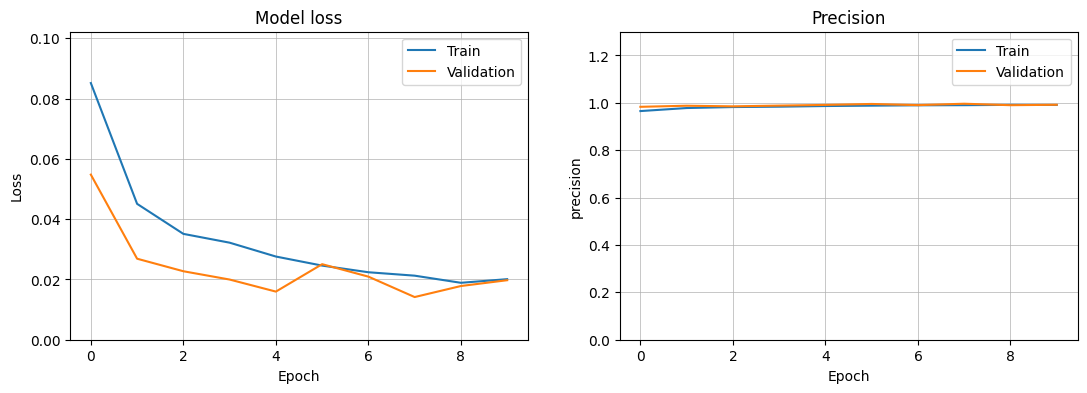

In [24]:
#metric names may change (eg precision->precision_1) yif you rerun fit cell manually !...
try: 
   plot_loss_history(history)
except : 
   pass

In [38]:
set_env_manual=False
if set_env_manual:
  os.environ['MODEL_TARGET'] = "mlflow"
  os.environ['MLFLOW_TRACKING_URI'] = "https://mlflow.lewagon.ai"
  os.environ['MLFLOW_EXPERIMENT'] = "mocap_2003_ds"
  os.environ['MLFLOW_MODEL_NAME'] = "full"
  os.environ['MLFLOW_STAGE'] = "staging"   

In [16]:
write_dot_env=True

if write_dot_env:
    have_it_already=!cat .envo 2>>/dev/null | grep MLFLOW_TRACKING_URI | wc -w
    if int(have_it_already[0]) == 0 :
      print("writing mlflow env into .env")
      !echo "MODEL_TARGET=local"                            >> .envo
      !echo "MLFLOW_TRACKING_URI=https://mlflow.lewagon.ai" >> .envo
      !echo 'MLFLOW_EXPERIMENT=mocap_2003_ds'               >> .envo
      !echo 'MLFLOW_MODEL_NAME=full'                        >> .envo
      !echo 'MLFLOW_STAGE=staging'                          >> .envo  

writing mlflow env into .env


In [42]:
model_taget=os.environ.get("MODEL_TARGET")

if model_taget is None : model_taget=""

params = dict( optimizer=optimizer_str, 
               batch_size=batch_size,
               learning_rate=initial_learning_rate,
               do_scale=do_scale,
               use_expo_decay=use_expo_decay )

metrics = dict(loss=loss, precision=precision, recall=recall, prc=prc )

if model_taget == "local" : 
   if save_model : 
      model.save(model_complexity)  
      print("model saved locally in {} dir".format(model_complexity))
   else:
      print("model is not saved")
elif model_taget == "mlflow" :
   try:
        print("save model to mlflow...")

        mlflow_tracking_uri = os.environ.get("MLFLOW_TRACKING_URI")
        mlflow_experiment = os.environ.get("MLFLOW_EXPERIMENT")
        mlflow_model_name = os.environ.get("MLFLOW_MODEL_NAME")
        
        if mlflow_tracking_uri != "" and mlflow_experiment != "" and mlflow_model_name != "" :
            mlflow.set_tracking_uri(mlflow_tracking_uri)
            mlflow.set_experiment(experiment_name=mlflow_experiment)

            with mlflow.start_run():                       
              if params is not None:
                  mlflow.log_params(params)

              if metrics is not None:
                  mlflow.log_metrics(metrics)

              if model is not None:
                  mlflow.keras.log_model(keras_model=model,  artifact_path="model",
                                         keras_module="tensorflow.keras",
                                         registered_model_name=mlflow_model_name)

            print("data saved to mlflow {} {} {} ok".format(mlflow_tracking_uri, mlflow_experiment, mlflow_model_name))
        else:
            print("mlflow env vars are missing or undefined...")
   except Exception as err:      
     print("error {} while saving model to mlflow".format(str(err)))

save model to mlflow...


2022/12/01 01:47:27 INFO mlflow.tracking.fluent: Experiment with name 'mocap_2003_ds' does not exist. Creating a new experiment.


INFO:tensorflow:Assets written to: /tmp/tmph0cawaka/model/data/model/assets


Successfully registered model 'full'.
2022/12/01 01:47:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: full, version 1


data saved to mlflow https://mlflow.lewagon.ai mocap_2003_ds full ok


Created version '1' of model 'full'.
